# Extracting Shapelets

In [18]:
import numpy as np
from pyts.transformation import ShapeletTransform

from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

%run ../sys_configs.ipynb
%run ../plots.ipynb

## Introduction

Shapelets are introduced in [1] as *snippets* of time series observations that can be used to classify an unlabelled time series, the distance between the unlabelled time series and the snippet being within a distance threshold.

If we let $X = (x_{1},...,x_{n})$ be a time series where $x_{i} \in \mathbb{R}^{6}$ and $S = (s_{1}, ..., s_{l})$ where $s_{j} \in \mathbb{R}^{6}$ define a shapelet of length $l$, then the distance between the time series and the shapelet is defined as:
$dist(S, X) = min_{j \in \{0, ..., n-l\}}\Sigma_{k=1}^{l}(s_{k} - x_{j+k})^{2}.$

Shapelet identification algorithms can fit into the special cases of either *shapelet discovery* or *shapelet learning* (via gradient descent). 

In [2]:
with open('../data/train.npy', 'rb') as f:
    x_train = np.load(f)
    y_train = np.load(f)
sz, dim = x_train.shape[1:]
    
with open('../data/val.npy', 'rb') as f:
    x_val = np.load(f)
    y_val = np.load(f)

with open('../data/test.npy', 'rb') as f:
    x_test = np.load(f)
    y_test = np.load(f)
    
classes = np.unique(y_train)  

N_train = len(y_train)
N_val = len(y_val)
N_test = len(y_test)

### Approach

The Shapelet Transform identifies all the shapelets with a length belonging to a pre-determined range and selects the best shapelets among these candidates. 

This is a multistep process. After extracting valid shapelets of varying lengths across the time series, the distance between each shapelet and time series is calculated using a metric like DTW or the Euclidean distance. The data is then transformed into a new feature space where each feature corresponds to the distance to a particular shapelet. We then compute the F-statistic for each shapelet to determine its discriminative power; the F-statistic compares the between group (class) variance with the within group variance and the most discriminative shapelets are those with the highest F-statistics. The shapelets are ranked based on their F-statistics and the shapelets with the highest F-statistics are chosen as the best shapelets for classification. Self-similar shapelets are then removed. Two shapelets are self similar if they are from the same time series and have a minimum of one overlapping index.

This all amounts to an exercise in feature selection. Once the shapelets are selected, it is possible to run all the usual classification techniques like nearest neighbours and support vector machines to complete the classification task.

The Shapelet Transform method is highly computationally expensive, on the order of $O(N^{2}n^{4})$ assuming there are N time series in the dataset. Shapelets do not easily extend to multi-dimensional time series and the Shapelet Transform has not been implemented in Pyts. We compute component-by-component Shapelet Transforms, identifying the most informative Shapelets in each and merging the result.

### Training

In [3]:
sample_size = N_train//8
print(f"Sample_size: {sample_size}")

# Choose the secondary sample indexes
random_idxs = np.random.choice(N_train, size = sample_size, replace=False)

# Obtain each of the 6 components of the sensor data
train_acc_x = x_train[random_idxs, :, 0]
train_acc_y = x_train[random_idxs, :, 1]
train_acc_z = x_train[random_idxs, :, 2]
train_gyr_x = x_train[random_idxs, :, 3]
train_gyr_y = x_train[random_idxs, :, 4]
train_gyr_z = x_train[random_idxs, :, 5]

# Obtain the corresponding class labels from the indexes
y_train = y_train[random_idxs]

Sample_size: 540


In [4]:
# Initialise, then fit, the Shapelet transform. It is better to let the ShapeletTransform decide the length of the shapelets automatically.
st_acc_x = ShapeletTransform(n_shapelets = 50, window_sizes=[5, 8], criterion = "anova", remove_similar = True)
st_acc_y = ShapeletTransform(n_shapelets = 50, window_sizes=[5, 8], criterion = "anova", remove_similar = True)
st_acc_z = ShapeletTransform(n_shapelets = 50, window_sizes=[5, 8], criterion = "anova", remove_similar = True)
st_gyr_x = ShapeletTransform(n_shapelets = 50, window_sizes=[5, 8], criterion = "anova", remove_similar = True)
st_gyr_y = ShapeletTransform(n_shapelets = 50, window_sizes=[5, 8], criterion = "anova", remove_similar = True)
st_gyr_z = ShapeletTransform(n_shapelets = 50, window_sizes=[5, 8], criterion = "anova", remove_similar = True)

In [5]:
acc_x_shapelets = st_acc_x.fit(train_acc_x, y_train)
acc_y_shapelets = st_acc_y.fit(train_acc_y, y_train)
acc_z_shapelets = st_acc_z.fit(train_acc_z, y_train)
gyr_x_shapelets = st_gyr_x.fit(train_gyr_x, y_train)
gyr_y_shapelets = st_gyr_y.fit(train_gyr_y, y_train)
gyr_z_shapelets = st_gyr_z.fit(train_gyr_z, y_train)

Now that the most discriminative Shapelets have been selected, we train a supervised machine learning model using the degree of similarity between each time series and each shapelet as the features.

In [6]:
# Extract the features as described above
train_acc_x_features = acc_x_shapelets.transform(train_acc_x)
train_acc_y_features = acc_y_shapelets.transform(train_acc_y)
train_acc_z_features = acc_z_shapelets.transform(train_acc_z)
train_gyr_x_features = gyr_x_shapelets.transform(train_gyr_x)
train_gyr_y_features = gyr_y_shapelets.transform(train_gyr_y)
train_gyr_z_features = gyr_z_shapelets.transform(train_gyr_z)

# Concatenate the features
train_features = np.hstack([train_acc_x_features, 
                            train_acc_y_features,
                            train_acc_z_features,
                            train_gyr_x_features,
                            train_gyr_y_features,
                            train_gyr_z_features
                           ])

In [7]:
knn = KNeighborsClassifier(n_neighbors=10, metric = "cosine")
knn.fit(train_features, y_train)

KNeighborsClassifier(metric='cosine', n_neighbors=10)

In [8]:
svc = svm.SVC(degree=3, C=0.5)
svc.fit(train_features, y_train)

SVC(C=0.5)

In [9]:
rfc = RandomForestClassifier(max_depth=2, n_estimators=100, min_samples_split=5, criterion = "gini")
rfc.fit(train_features, y_train)

RandomForestClassifier(max_depth=2, min_samples_split=5)

### Predict

In [10]:
# Obtain each of the 6 components of the sensor data
val_acc_x = x_val[:, :, 0]
val_acc_y = x_val[:, :, 1]
val_acc_z = x_val[:, :, 2]
val_gyr_x = x_val[:, :, 3]
val_gyr_y = x_val[:, :, 4]
val_gyr_z = x_val[:, :, 5]

test_acc_x = x_test[:, :, 0]
test_acc_y = x_test[:, :, 1]
test_acc_z = x_test[:, :, 2]
test_gyr_x = x_test[:, :, 3]
test_gyr_y = x_test[:, :, 4]
test_gyr_z = x_test[:, :, 5]

In [11]:
val_acc_x_features = acc_x_shapelets.transform(val_acc_x)
val_acc_y_features = acc_y_shapelets.transform(val_acc_y)
val_acc_z_features = acc_z_shapelets.transform(val_acc_z)
val_gyr_x_features = gyr_x_shapelets.transform(val_gyr_x)
val_gyr_y_features = gyr_y_shapelets.transform(val_gyr_y)
val_gyr_z_features = gyr_z_shapelets.transform(val_gyr_z)

test_acc_x_features = acc_x_shapelets.transform(test_acc_x)
test_acc_y_features = acc_y_shapelets.transform(test_acc_y)
test_acc_z_features = acc_z_shapelets.transform(test_acc_z)
test_gyr_x_features = gyr_x_shapelets.transform(test_gyr_x)
test_gyr_y_features = gyr_y_shapelets.transform(test_gyr_y)
test_gyr_z_features = gyr_z_shapelets.transform(test_gyr_z)

In [12]:
val_features = np.hstack([val_acc_x_features, 
                          val_acc_y_features,
                          val_acc_z_features,
                          val_gyr_x_features,
                          val_gyr_y_features,
                          val_gyr_z_features
                          ])

test_features = np.hstack([test_acc_x_features, 
                           test_acc_y_features,
                           test_acc_z_features,
                           test_gyr_x_features,
                           test_gyr_y_features,
                           test_gyr_z_features
                          ])

In [14]:
predictions_val = knn.predict(val_features)
predictions_test = knn.predict(test_features)

In [15]:
# Compare predictions against the targets
print("Validation Data - Total predictions made: %s. Number of correct predictions: %s" % (len(predictions_val), sum(np.equal(predictions_val, y_val))))
print("Test Data - Total predictions made: %s. Number of correct predictions: %s" % (len(predictions_test), sum(np.equal(predictions_test, y_test))))

Validation Data - Total predictions made: 1392. Number of correct predictions: 668
Test Data - Total predictions made: 1051. Number of correct predictions: 493


The problem with this approach is that it cannot scale. Operations on a sample of just 100 mean we can expect just 2-3 samples of each class to train on. This would explain why the performance of the classifiers is so weak.

### Visualise predictions for test set

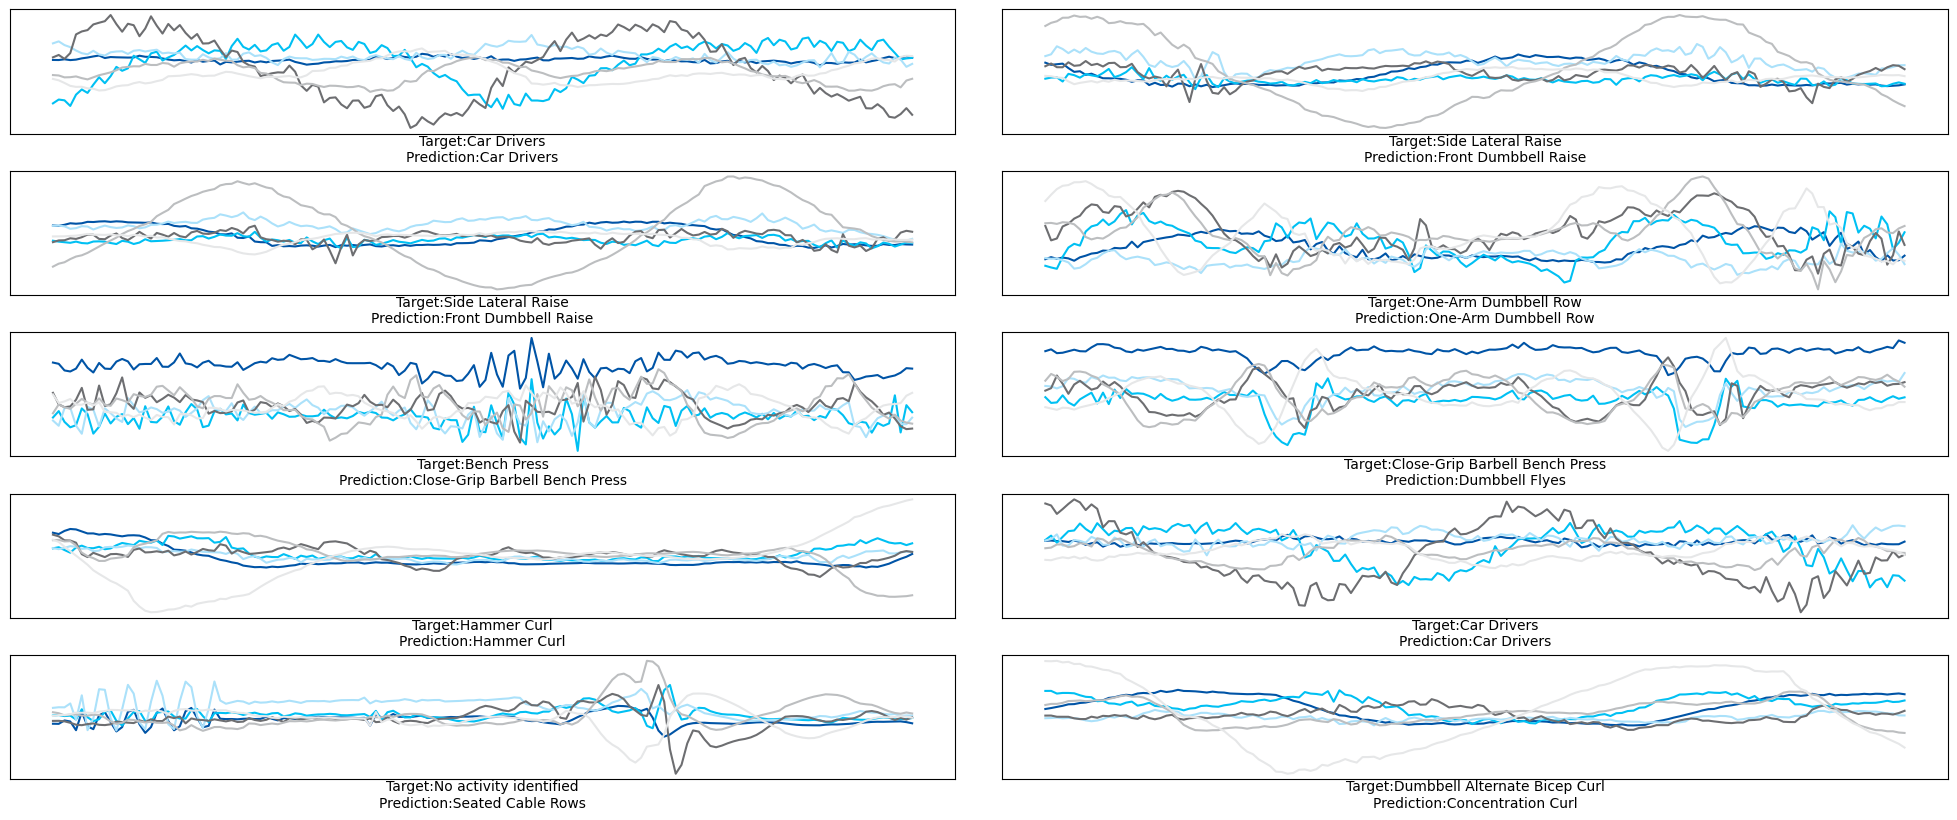

In [16]:
plot_samples(data = x_test, labels = y_test, predictions = predictions_test)

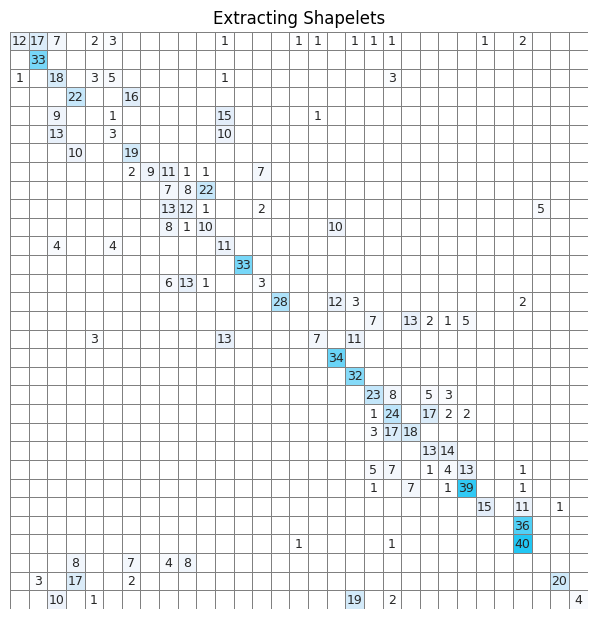

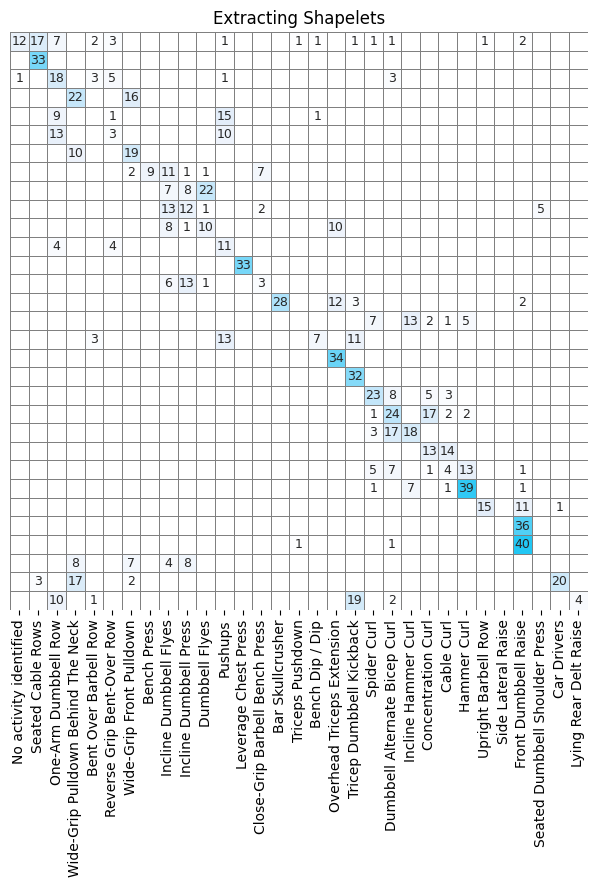

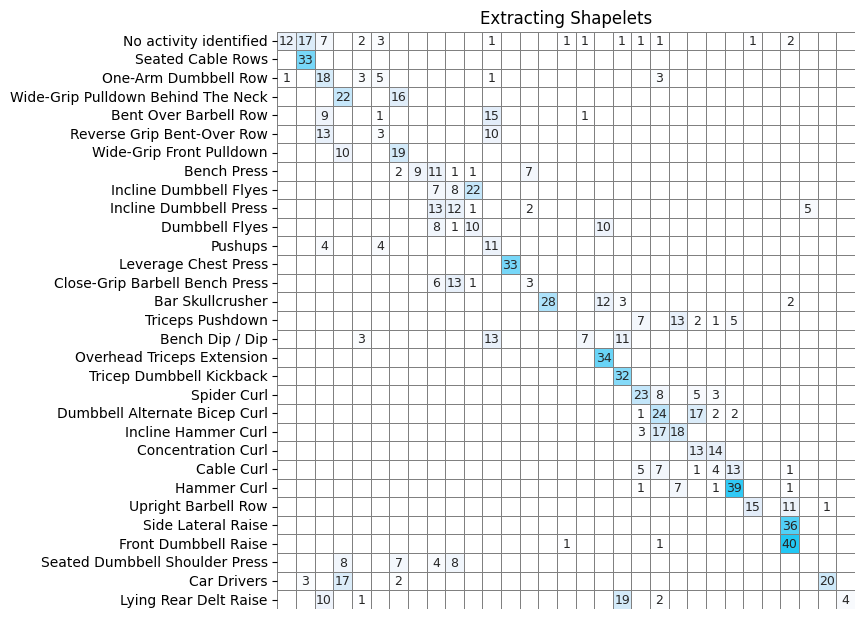

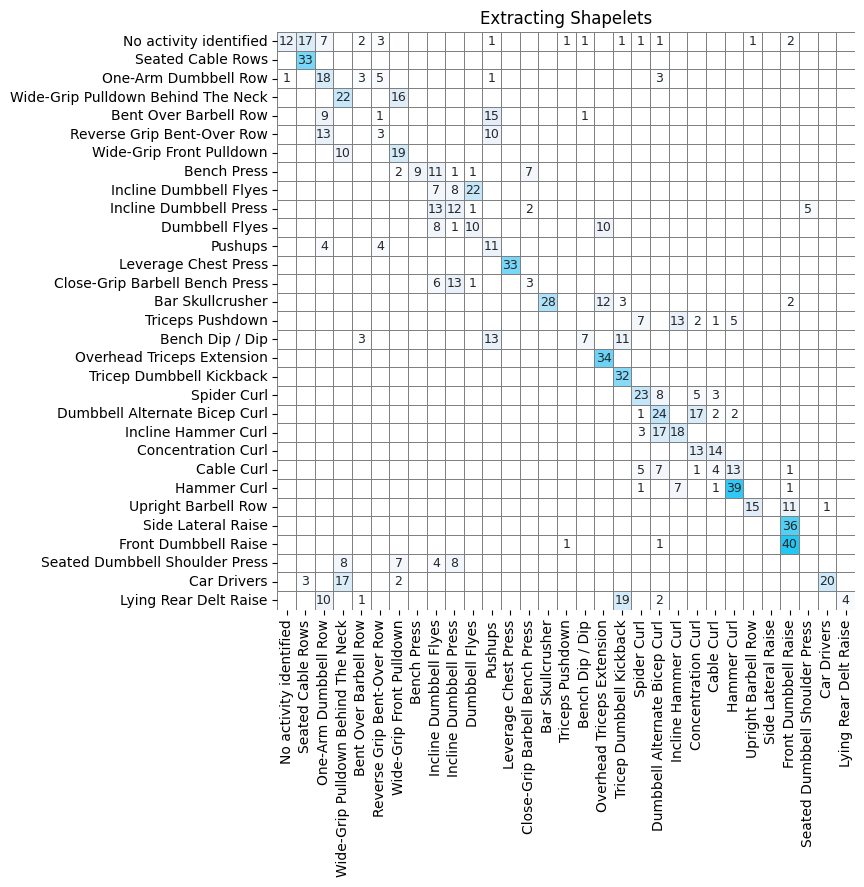

In [19]:
cm = confusion_matrix(y_test, predictions_test, labels = classes)

# Save 4 copies of the confusion matrix, with different permutations of x_ticks and y_ticks turned on
plot_confusion_matrix(cm, x_ticks = False, y_ticks = False, save = True, title = "Extracting Shapelets")
plot_confusion_matrix(cm, x_ticks = True, y_ticks = False, save = True, title = "Extracting Shapelets")
plot_confusion_matrix(cm, x_ticks = False, y_ticks = True, save = True, title = "Extracting Shapelets")
plot_confusion_matrix(cm, x_ticks = True, y_ticks = True, save = True, title = "Extracting Shapelets")

## References

[1] Keogh, Eamonn J. and Thanawin Rakthanmanon. “Fast Shapelets: A Scalable Algorithm for Discovering Time Series Shapelets.” SDM (2013).

[2] Lines, Jason, Luke M. Davis, Jon Hills and A. Bagnall. “A shapelet transform for time series classification.” Knowledge Discovery and Data Mining (2012).